## <u> Data Modelling </u>

This notebook implements a binary classification model to predict loan default risk using logistic regression and gradient boosted decision trees. The modeling workflow follows a systematic approach by splitting the dataset into training, validation, and test sets, conducting hyperparameter tuning via cross-validation on the training set, and evaluating final model performance on the test set. A logistic regression baseline is established first to quantify the performance gain from the more complex gradient boosting approach. Given the class imbalance inherent to credit default datasets, appropriate evaluation metrics and sampling strategies are employed throughout the modeling process to ensure robust model assessment.

### <u> 1. Setup</u>

In [1]:
# Import necessary libraries
import pandas as pd, sys
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix,
    classification_report, roc_auc_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer


import matplotlib.pyplot as plt
import numpy as np
import joblib

In [2]:
# Import final dataset
home_credit = pd.read_csv('../data/processed/home_credit_final.csv', index_col=0)

# Ensure categorical columns are of type 'category'
cat_cols = home_credit.select_dtypes(include="object").columns
for col in cat_cols:
    home_credit[col] = home_credit[col].astype("category")

home_credit.head(3)

,EXT_SOURCE_3,EXT_SOURCE_1,EXT_SOURCE_2,YEARS_EMPLOYED,YEARS_BIRTH,OCCUPATION_TYPE,ORGANIZATION_TYPE,NAME_INCOME_TYPE,REG_CITY_NOT_WORK_CITY,YEARS_LAST_PHONE_CHANGE,...,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,FLAG_OWN_CAR,CODE_GENDER,AMT_ANNUITY,prev_cnt_revolving_refused,prev_has_history,prev_cnt_revolving_canceled,prev_cnt_cash_refused,TARGET
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
149977,0.567379,NaN,0.318931,13.8,47.1,Laborers,Industry: type 7,Working,0,5.3,...,2,14,1,M,37800.0,0,1,0,0,0
149261,0.197475,0.37669,0.121854,1.2,35.7,Private service staff,Self-employed,Working,1,0.2,...,2,9,0,F,27652.5,0,1,0,1,1
451117,NaN,NaN,0.162192,24.2,42.3,Laborers,Industry: type 11,Working,0,2.4,...,2,12,0,F,11101.5,0,1,0,0,0


### <u> 2. Modelling Pipeline</u>

Given the early inspection of the variables, the modeling strategy begins with **logistic regression** as a baseline to establish interpretable performance benchmarks, followed by **gradient boosted trees** as a more complex extension better suited to the dataset's characteristics.

The primary motivation for adopting gradient boosted trees lies in their native handling of missing values and mixed variable types. Missing values in this dataset carry meaningful predictive signal, and the feature set comprises both numerical and categorical variables. Gradient boosted trees process these characteristics directly without requiring preprocessing, whereas logistic regression necessitates one-hot encoding of categorical variables and imputation of missing values across the five features in question. This preprocessing would effectively introduce synthetic data into variables that are highly correlated with the target response, potentially distorting the very patterns we aim to capture.

Among the two leading implementations, LightGBM and XGBoost, the former was selected given the medium-large sample size of the training set, along with its faster training speed and more efficient memory usage when processing large feature spaces. These properties make **LightGBM** particularly well suited to our setting, where the dataset comprises approximately 300,000 observations and the modeling pipeline is expected to be iterated upon multiple times during the tuning phase.

#### <u> 2.1 Train and Test Set</u>

A 80/20 stratified split was adopted to allocate the largest share of observations to training, while ensuring the 8% default rate is preserved across both sets through stratification on the response variable. The training set is used to train the model and, under cross validation, also to tune the hyperparameters. The test set is used to assess the model's ability to generalise on unseen data. This two-way structure prevents information leakage by keeping the test set completely isolated throughout the entire modelling process.

In [3]:
X = home_credit.drop(columns=['TARGET'])
y = home_credit['TARGET']

# 80/20 Stratified split on response variable
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=12, stratify=y
)

# Check ratios and sizes
for name, target in [('Train', y_train), ('Evaluation', y_test)]:
    print(f"{name:>12} | Size: {len(target):>6} | Default rate: {target.mean():.4f}")


       Train | Size: 246008 | Default rate: 0.0807
  Evaluation | Size:  61503 | Default rate: 0.0807


### <u>2. Logistic regression</u>
#### <u> 2.1 Data Preparation</u>
Unlike LightGBM, logistic regression requires explicit handling of missing values and categorical variables. To tackle this limitation, missing values are imputed using the median for numerical features and the mode for categorical features. One-hot encoding is then applied to categorical variables to capture their distinct categories in a form the model can process, which expands the feature space given that several features contain multiple categories as observed during EDA. Finally, nuerical features are standardized to ensure numerical stability during optimization and to enable fair comparison of regularization penalties across features with different scales.

In [78]:
# Numerical features
numerical_features = [
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 
    'YEARS_EMPLOYED', 'OWN_CAR_AGE', 'YEARS_BIRTH',
    'YEARS_REGISTRATION', 'YEARS_ID_PUBLISH', 'YEARS_LAST_PHONE_CHANGE',
    'REGION_POPULATION_RELATIVE', 'AMT_CREDIT', 'AMT_ANNUITY',
    'HOUR_APPR_PROCESS_START', 'REGION_RATING_CLIENT_W_CITY',
    'bur_cnt_active', 'prev_cnt_consumer_approved', 
    'prev_cnt_revolving_refused', 'prev_cnt_revolving_canceled', 
    'prev_cnt_cash_refused'
]

# Categorical and binary features
categorical_features = [
    'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE',
    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_CONTRACT_TYPE',
    'NAME_EDUCATION_TYPE', 'CODE_GENDER',
    'REG_CITY_NOT_WORK_CITY', 'REG_CITY_NOT_LIVE_CITY',
    'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_6', 'FLAG_WORK_PHONE', 
    'FLAG_PHONE', 'FLAG_OWN_CAR', 'bur_has_history', 'prev_has_history'
]

# Numerical pipeline: impute with median, then standardize
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline: impute with mode, then one-hot encode
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Combine both pipelines
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
], remainder='passthrough')

#### <u> 2.2 Hyperparameters Search</u>

In [80]:
# Full pipeline with logistic regression
logistic_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=500, random_state=12, class_weight='balanced'))
])

# Define hyperparameter grid
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

# Grid search with stratified CV
logistic_cv = GridSearchCV(
    logistic_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=2,
    verbose=1
)


In [ ]:

# Fit on training data
logistic_cv.fit(X_train, y_train)

# Best parameters and score
print(f"Best parameters: {logistic_cv.best_params_}")
print(f"Best CV ROC-AUC: {logistic_cv.best_score_:.4f}")

# Save grid search results
# joblib.dump(logistic_cv, 'grid_search_logistic.pkl')

# Get best model
best_logistic = logistic_cv.best_estimator_

#### <u> 2.3 Threshold selection</u>

To ensure no data leakage, the optimal threshold is estimated across the cross validation folds of the best configuration rather than on the test set. For each fold, the point on the ROC curve closest to (0, 1) is identified, as this represents the best trade-off between catching defaults and preserving good customers. The thresholds obtained across the five folds are then averaged to produce a single stable estimate, which is applied during the final evaluation on the test set.


In [83]:
# Load grid search results
logistic_cv = joblib.load('grid_search_logistic.pkl')


# Extract best parameters from grid search
best_model_params_lr = logistic_cv.best_params_

# Pipeline for best model
best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        C=best_model_params_lr['classifier__C'],
        penalty=best_model_params_lr['classifier__penalty'],
        solver=best_model_params_lr['classifier__solver'],
        max_iter=1000,
        random_state=12,
        class_weight='balanced'
    ))
])

# Find optimal threshold via CV
thresholds_per_fold = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

for train_idx, val_idx in cv.split(X_train, y_train):
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train model with best parameters
    best_pipeline.fit(X_fold_train, y_fold_train)

    # Predict probabilities on the held-out fold
    y_fold_prob = best_pipeline.predict_proba(X_fold_val)[:, 1]

    # Compute ROC and find optimal threshold
    fpr, tpr, thresh = roc_curve(y_fold_val, y_fold_prob)
    distances = np.sqrt(fpr**2 + (tpr - 1)**2)
    optimal_idx = np.argmin(distances)
    thresholds_per_fold.append(thresh[optimal_idx])

# Average threshold across folds
optimal_threshold_lr = np.mean(thresholds_per_fold)

print(f"Threshold per fold: {thresholds_per_fold}")
print(f"Averaged Optimal Threshold: {optimal_threshold_lr:.4f}")

Threshold per fold: [0.5083824532645963, 0.48269421807334084, 0.49774339412210145, 0.5001655444191085, 0.5029080374307071]
Averaged Optimal Threshold: 0.4984


In [85]:
# Number of features before and after preprocessing
n_features_before = X_train.shape[1]
n_features_after = logistic_cv.best_estimator_.named_steps['classifier'].coef_.shape[1]
print(f"Number of features before preprocessing: {n_features_before}")
print(f"Number of features after preprocessing: {n_features_after}")

Number of features before preprocessing: 36
Number of features after preprocessing: 106


#### <u> 2.4 Model Evaluation</u>

In [86]:
# Compute probabilities and predictions based on optimal threshold
y_test_proba_lr = logistic_cv.best_estimator_.predict_proba(X_test)[:, 1]
y_test_pred_lr = (y_test_proba_lr >= optimal_threshold_lr).astype(int)

# ROC-AUC Score
roc_auc_lr = roc_auc_score(y_test, y_test_proba_lr,)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_test_proba_lr)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_lr, target_names=['No Default', 'Default'], digits=3))
print(f"AUC on Test Set: {roc_auc_lr:.4f}")


Classification Report:
              precision    recall  f1-score   support

  No Default      0.961     0.688     0.802     56538
     Default      0.160     0.678     0.259      4965

    accuracy                          0.687     61503
   macro avg      0.560     0.683     0.531     61503
weighted avg      0.896     0.687     0.758     61503

AUC on Test Set: 0.7483


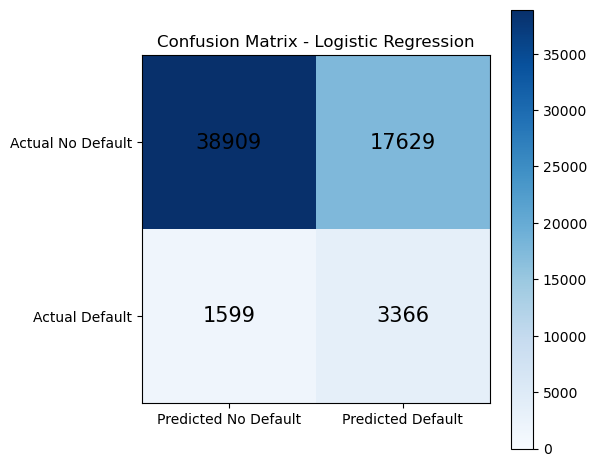

In [87]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred_lr)
plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap='Blues', vmin=0, vmax=cm.max() * 1)
plt.colorbar()
plt.xticks([0, 1], ['Predicted No Default', 'Predicted Default'])
plt.yticks([0, 1], ['Actual No Default', 'Actual Default'])
plt.title('Confusion Matrix - Logistic Regression')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=15)
plt.tight_layout()
plt.show()

### <u>3. LightGBM</u>
#### <u> 3.1 Hyperparameters Search</u>

In order to find the optimal hyperparameters for the LightGBM model, a cross validation procedure is applied over the training set. While a deeper search of the hyperparameter space is possible, a light but context-driven approach is adopted here to avoid an inefficient and blind exploration. In terms of evaluation metric, AUC is used as the scoring criterion given the imbalanced nature of the response variable. In this context AUC measures the model's overall ability to separate defaults from non-defaults across all possible classification thresholds, making it the most appropriate metric at this stage. The selection of the optimal threshold is then based on the cost asymmetry between false negatives and false positives will be addressed during the final evaluation on the test set.

In [4]:
# Base parameters for LightGBM
base_params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'random_state': 12,
    'min_child_samples': 50,
}


# Grid search parameters
param_grid = {
    'n_estimators': [350, 500],
    'learning_rate': [0.01, 0.05],
    'scale_pos_weight': [((1 - 0.08) / 0.08)/4, 1], # 2.875 vs 1 to address class imbalance
    'num_leaves': [30, 50],
    'max_depth': [6,8]
}


# Initialize StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

# Set up GridSearchCV over hyperparameters grid
grid_search = GridSearchCV(
    estimator=lgb.LGBMClassifier(**base_params),
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=2,
    verbose=1,
    return_train_score=True
)

In [ ]:
# Fit grid search
grid_search.fit(X_train, y_train)

# Print best score and parameters
print(f"Best AUC: {grid_search.best_score_:.4f}")
print(f"Best Parameters: {grid_search.best_params_}")

# Save grid search results
# joblib.dump(grid_search, 'grid_search_lgbm.pkl')

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best AUC: 0.7570
Best Parameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 350, 'num_leaves': 30, 'scale_pos_weight': 1}


['grid_search_lgbm.pkl']

#### <u> 3.2 Optimal Threshold</u>

In [5]:
# Load grid search results
grid_search = joblib.load('grid_search_lgbm.pkl')

# Set best paramters from grid search
best_model_params = grid_search.best_estimator_.get_params()
thresholds_per_fold = []

for train_idx, val_idx in cv.split(X_train, y_train):
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train model with best parameters
    model = lgb.LGBMClassifier(**best_model_params)
    model.fit(X_fold_train, y_fold_train)

    # Predict probabilities on the held-out fold
    y_fold_prob = model.predict_proba(X_fold_val)[:, 1]

    # Compute ROC and find optimal threshold
    fpr, tpr, thresh = roc_curve(y_fold_val, y_fold_prob)
    distances = np.sqrt(fpr**2 + (tpr - 1)**2)
    optimal_idx = np.argmin(distances)
    thresholds_per_fold.append(thresh[optimal_idx])

# Average threshold across folds
optimal_threshold = np.mean(thresholds_per_fold)

print(f"Threshold per fold: {thresholds_per_fold}")
print(f"Averaged Optimal Threshold: {optimal_threshold:.4f}")

Threshold per fold: [0.08038581460569101, 0.07336146162559902, 0.07663142734286, 0.07630651669996, 0.0773673668140089]
Averaged Optimal Threshold: 0.0768


#### <u> 3.3 Model evaluation</u>

In [8]:
# Predict default probabilities on test set using best model 
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Compute ROC-AUC score
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Assign predictions based on CV optimal threshold
y_pred = (y_prob >= optimal_threshold).astype(int)


# Classification report
print(classification_report(y_test, y_pred, target_names=['No Default', 'Default'], digits=3))

# AUC
print(f"\nAUC on Test Set: {roc_auc:.4f}")

              precision    recall  f1-score   support

  No Default      0.963     0.690     0.804     56538
     Default      0.164     0.695     0.266      4965

    accuracy                          0.690     61503
   macro avg      0.564     0.692     0.535     61503
weighted avg      0.898     0.690     0.760     61503


AUC on Test Set: 0.7582


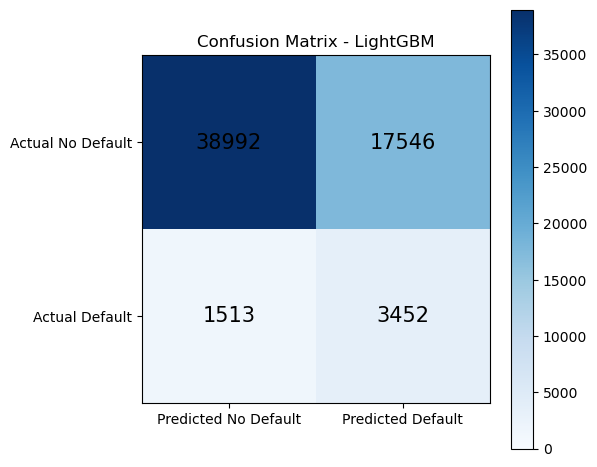

In [9]:
# Confusion matrix

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap='Blues', vmin=0, vmax=cm.max() * 1)
plt.colorbar()
plt.xticks([0, 1], ['Predicted No Default', 'Predicted Default'])
plt.yticks([0, 1], ['Actual No Default', 'Actual Default'])
plt.title('Confusion Matrix - LightGBM')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=15)
plt.tight_layout()
plt.show()

In [10]:
# Find closest point in the thresholds to the optimal threshold from CV
distances = np.abs(thresholds - optimal_threshold)
optimal_idx_cv = np.argmin(distances)

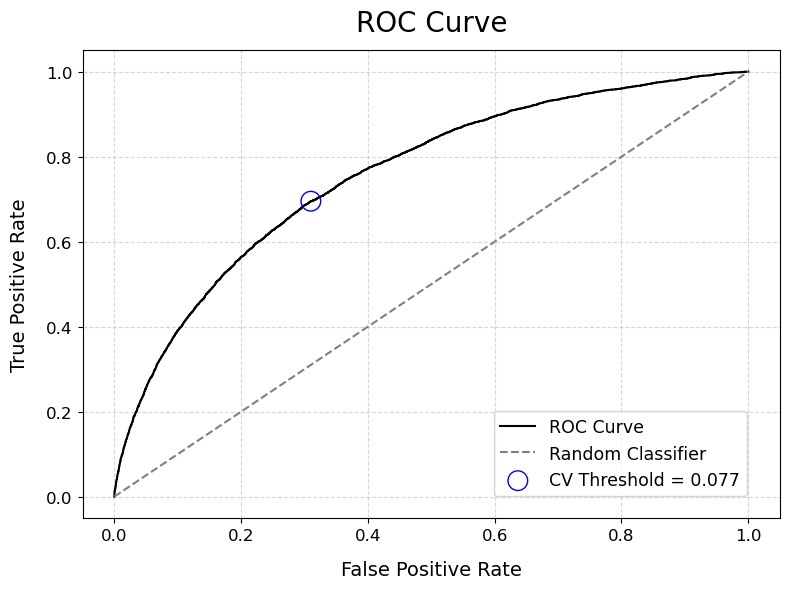

In [11]:
# Plot AUC-ROC curve with CV and test thresholds
plt.figure(figsize=(8, 6))

# Plot ROC curve for LightGBM
plt.plot(fpr, tpr, color='black', label=f'ROC Curve')


# Plot ROC curve random classifier line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')


# Plot optimal thresholds
plt.scatter(fpr[optimal_idx_cv], tpr[optimal_idx_cv], color='blue', s=200, zorder=5, marker= 'o', facecolors='none',
            label=f'CV Threshold = {optimal_threshold:.3f}')


plt.xlabel('False Positive Rate', labelpad=12.5, fontsize=14)
plt.ylabel('True Positive Rate', labelpad=12.5, fontsize=14)
plt.title('ROC Curve', fontsize=20, pad=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=12.5, bbox_to_anchor=(0.965, 0.028))
plt.grid(True, alpha=0.5, linestyle='--')
plt.tight_layout()
plt.savefig('../images/roc_curve_lgbm.png', dpi=600, bbox_inches='tight')
plt.show()


In [12]:
comparison = pd.DataFrame({
    'Metric': ['Precision - Default', 'Recall - Default', 'F1 - Default', 'Accuracy', 'AUC'],
    'LightGBM': [0.164, 0.695, 0.266, 0.690, 0.7582],
    'Logistic Reg': [0.160, 0.678, 0.259, 0.687, 0.7483]
})

comparison['Difference'] = comparison['LightGBM'] - comparison['Logistic Reg']
comparison = comparison.map(lambda x: f"{x:.3f}" if isinstance(x, (int, float)) else x)
comparison

,Metric,LightGBM,Logistic Reg,Difference
0,Precision - Default,0.164,0.160,0.004
1,Recall - Default,0.695,0.678,0.017
2,F1 - Default,0.266,0.259,0.007
3,Accuracy,0.690,0.687,0.003
4,AUC,0.758,0.748,0.010


<u> **Comment:**</u>


Both models demonstrate similar performance, with LightGBM achieving marginally higher AUC (0.758 vs 0.748) and recall (69.5% vs 67.8%), suggesting both models are extracting comparable predictive signal from the feature set. However, logistic regression exhibits significantly longer training times due to computational inefficiency with the high-dimensional sparse matrices created by one-hot encoding of categorical variables. Given that recall is the primary evaluation metric for default prevention, and considering LightGBM's computational advantages with native categorical handling, LightGBM was selected as the final model.

#### <u> 3.4 Feature importance</u>

In [90]:

# Extract the feature importnace from the best model
best_model = grid_search.best_estimator_
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

# Add rank column based on importance
importance_df['rank'] = range(1, len(importance_df) + 1)

# Save for PowerBI
importance_df.to_excel('../data/processed/feature_importance.xlsx', index=False)
print(importance_df)

                        feature  importance  rank
0             ORGANIZATION_TYPE        1498     1
1                  EXT_SOURCE_1         792     2
2                  EXT_SOURCE_3         726     3
3                  EXT_SOURCE_2         702     4
4                    AMT_CREDIT         661     5
5                   YEARS_BIRTH         580     6
6                   AMT_ANNUITY         523     7
7               OCCUPATION_TYPE         497     8
8                YEARS_EMPLOYED         483     9
9            YEARS_REGISTRATION         449    10
10             YEARS_ID_PUBLISH         422    11
11   REGION_POPULATION_RELATIVE         354    12
12      YEARS_LAST_PHONE_CHANGE         314    13
13                  OWN_CAR_AGE         281    14
14               bur_cnt_active         256    15
15      HOUR_APPR_PROCESS_START         238    16
16   prev_cnt_consumer_approved         219    17
17        prev_cnt_cash_refused         194    18
18                  CODE_GENDER         102    19


<u>**Comment:**</u>


By observing the ranked feature importances, `ORGANIZATION_TYPE` largely surpasses the `EXT_SOURCE` variables previously identified as strongest by the phi-k correlation analysis. The likely reason lies in the nature of decision tree modelling, which builds complex separations across the 42 categories of `ORGANIZATION_TYPE` through deeper splits, capturing patterns that the pairwise phi-k correlation was unable to detect. Other categorical variables such as `OCCUPATION_TYPE` follow a similar pattern. Overall, aside from a few FLAG variables at the bottom of the ranking, the model appears to extract meaningful signal from the majority of the features provided, justifying the feature engineering and selection work conducted in the earlier stages of the project.

#### <u> 3.5 Prediction dataframe</u>

In [91]:
# Predictions on train set 
y_train_prob = grid_search.best_estimator_.predict_proba(X_train)[:, 1]

train_df = pd.DataFrame({
    'SK_ID_CURR': X_train.index,
    'actual': y_train.values,
    'predicted_probability': y_train_prob,
    'predicted_class': (y_train_prob >= optimal_threshold).astype(int),
    'split': 'train'
})

# Predictions on test set
test_df = pd.DataFrame({
    'SK_ID_CURR': X_test.index,
    'actual': y_test.values,
    'predicted_probability': y_prob,
    'predicted_class': (y_prob >= optimal_threshold).astype(int),
    'split': 'test'
})


# Merge train and test predictions
predictions_df = pd.concat([train_df, test_df], ignore_index=True)

# Export
predictions_df.to_csv('../data/processed/model_predictions.csv', index=False)

In [92]:
predictions_df.head()

,SK_ID_CURR,actual,predicted_probability,predicted_class,split
0,176861,0,0.028455,0,train
1,149455,0,0.070056,0,train
2,313664,0,0.071736,0,train
3,173192,0,0.012465,0,train
4,125278,0,0.035392,0,train
